# White-box Evasion Attack on Random Forest IDS Model

In this notebook, we perform a **white-box adversarial attack** on a trained Random Forest classifier used for intrusion detection.  
We assume full access to the model (features, structure, thresholds). We'll:
- Load the real traffic data (benign + attack)
- Use perturbation logic to craft adversarial examples
- Evaluate pre-attack and post-attack performance
- Display all metrics (accuracy, precision, recall, F1, confusion matrix)


In [1]:
import os
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

import warnings

# Suppress warnings
warnings.simplefilter("ignore", category=FutureWarning)

## 1. Data and Model Loading, Feature Alignment, and Preprocessing

We'll align the real traffic features with the original CIC dataset used to train the model.
Missing values will be replaced with `0` to ensure clean input.


In [2]:
# === Paths ===
model_path = '../../models/5_supervised_real_traffic_test/model.joblib'
benign_path = '../../real_data/benign'
attack_path = '../../real_data/attack'
reference_csv = '../../data/cleaned_cic.csv'

# === Load model ===
model = joblib.load(model_path)

# === Helper to load data ===
def load_labeled_csvs(folder, label):
    dfs = []
    for fname in os.listdir(folder):
        if fname.endswith('.csv'):
            df = pd.read_csv(os.path.join(folder, fname))
            df['attack'] = label
            dfs.append(df)
    return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

# === Load and combine real traffic ===
benign_df = load_labeled_csvs(benign_path, 0)
attack_df = load_labeled_csvs(attack_path, 1)
combined_df = pd.concat([benign_df, attack_df], ignore_index=True)

print(f"Loaded traffic: {len(benign_df)} benign, {len(attack_df)} attack samples")


Loaded traffic: 964995 benign, 1067088 attack samples


In [3]:
# === Load reference features from original CIC dataset ===
ref_df = pd.read_csv(reference_csv)
expected_features = ref_df.select_dtypes(include=[np.number]).drop(columns=['attack']).columns.tolist()

# === Extract features and labels ===
X = combined_df[expected_features].fillna(0)
y = combined_df['attack'].astype(int)

print(f"Input matrix shape: {X.shape}, with {len(expected_features)} features")


Input matrix shape: (2032083, 77), with 77 features


## 2. Baseline Model Performance (Before Attack)

We now evaluate the classifier's performance on the unmodified real traffic.
This gives us a benchmark to compare how adversarial perturbations impact detection.


Pre-Attack Metrics:
Accuracy:  0.8820
Precision: 0.8165
Recall:    1.0000
F1-Score:  0.8990
ROC AUC:   0.9335
Classification Report – After Attack 1:
              precision    recall  f1-score   support

      Benign       1.00      0.75      0.86    964995
      Attack       0.82      1.00      0.90   1067088

    accuracy                           0.88   2032083
   macro avg       0.91      0.88      0.88   2032083
weighted avg       0.90      0.88      0.88   2032083



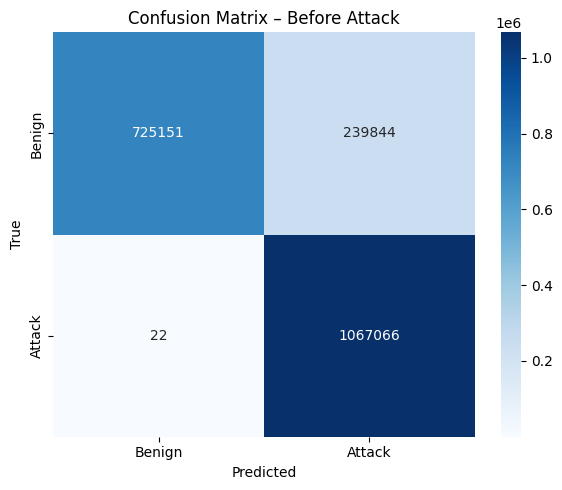

In [4]:
# === Predict on original data ===
y_pred = model.predict(X)
y_prob = model.predict_proba(X)[:, 1]

# === Metrics before adversarial modification ===
acc = accuracy_score(y, y_pred)
prec = precision_score(y, y_pred)
rec = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)
auc = roc_auc_score(y, y_prob)

print("Pre-Attack Metrics:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC AUC:   {auc:.4f}")

# === Metrics and confusion matrix
print("Classification Report – After Attack 1:")
print(classification_report(y, y_pred, target_names=["Benign", "Attack"]))

# === Confusion Matrix ===
cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Attack'], yticklabels=['Benign', 'Attack'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – Before Attack")
plt.tight_layout()
plt.show()



## Evaluate Attack
Helper Function to define and print key metrics for analysis.

In [5]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def evaluate_attack(y_true, y_pred, y_scores, title=""):
    # Metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_scores)

    # Evasion Rate: % of actual attacks misclassified as benign
    attack_mask = (y_true == 1)
    evaded = np.sum((y_true == 1) & (y_pred == 0))
    total_attacks = np.sum(attack_mask)
    evasion_rate = evaded / total_attacks if total_attacks > 0 else 0

    # Print report
    print(f"Classification Report – {title}")
    print(classification_report(y_true, y_pred, target_names=["Benign", "Attack"]))
    print(f"Accuracy:         {acc:.4f}")
    print(f"Precision:        {prec:.4f}")
    print(f"Recall:           {rec:.4f}")
    print(f"F1-Score:         {f1:.4f}")
    print(f"ROC AUC:          {auc:.4f}")
    print(f"Evasion Rate:  {evasion_rate:.4%} ({evaded} of {total_attacks} attacks evaded)")

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=['Benign', 'Attack'], yticklabels=['Benign', 'Attack'])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix – {title}")
    plt.tight_layout()
    plt.show()


## White-box Attack 1: Simple Fixed Perturbation on Key Features

We perform a naive adversarial attack by reducing the values of known high-impact features  
(e.g., packet sizes, durations, flow rates) in the attack samples by 5%.

This simulates an attacker attempting basic evasion without any adaptive logic.

We then evaluate the model’s ability to detect these perturbed attacks.


Applied -25% perturbation to 8 features on 1067088 attack samples
Classification Report – White-box Attack 1 – Strong Fixed Perturbation
              precision    recall  f1-score   support

      Benign       1.00      0.75      0.86    964995
      Attack       0.82      1.00      0.90   1067088

    accuracy                           0.88   2032083
   macro avg       0.91      0.88      0.88   2032083
weighted avg       0.90      0.88      0.88   2032083

Accuracy:         0.8820
Precision:        0.8165
Recall:           1.0000
F1-Score:         0.8990
ROC AUC:          0.9335
Evasion Rate:  0.0021% (22 of 1067088 attacks evaded)


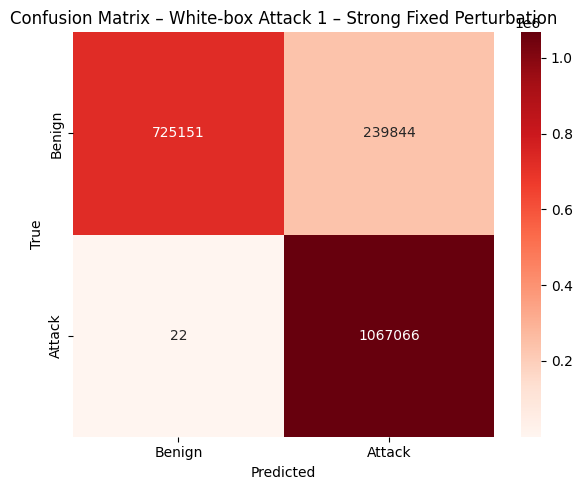

In [6]:
# === Copy and apply a stronger, one-sided attack
X_adv1 = X.copy()
y_adv1 = y.copy()
epsilon = 0.25  # stronger perturbation: reduce 25% of key features

features_to_perturb_1 = [
    "flow duration",
    "total length of fwd packets",
    "total length of bwd packets",
    "fwd packet length mean",
    "bwd packet length mean",
    "flow iat mean",
    "fwd packets/s",
    "ack flag count"
]

attack_indices = y_adv1[y_adv1 == 1].index
for feat in features_to_perturb_1:
    if feat in X_adv1.columns:
        X_adv1.loc[attack_indices, feat] *= (1 - epsilon)

print(f"Applied -25% perturbation to {len(features_to_perturb_1)} features on {len(attack_indices)} attack samples")

# === Evaluate
y_pred_adv1 = model.predict(X_adv1)
y_prob_adv1 = model.predict_proba(X_adv1)[:, 1]
evaluate_attack(y, y_pred_adv1, y_prob_adv1, title="White-box Attack 1 – Strong Fixed Perturbation")


## White-box Attack 2: Adaptive Perturbation Based on Feature Magnitude

This attack adapts the perturbation strength based on the magnitude of each feature value.

The logic:
- If a feature has a small value → larger perturbation (up to 10%)
- If it has a large value → smaller perturbation (1–3%)

This simulates more strategic evasion, especially where packet-level values are easy to manipulate.


Applied aggressive adaptive perturbation to 8 features
Classification Report – White-box Attack 2 – Aggressive Adaptive Perturbation
              precision    recall  f1-score   support

      Benign       1.00      0.75      0.86    964995
      Attack       0.82      1.00      0.90   1067088

    accuracy                           0.88   2032083
   macro avg       0.91      0.88      0.88   2032083
weighted avg       0.90      0.88      0.88   2032083

Accuracy:         0.8820
Precision:        0.8165
Recall:           1.0000
F1-Score:         0.8990
ROC AUC:          0.9344
Evasion Rate:  0.0021% (22 of 1067088 attacks evaded)


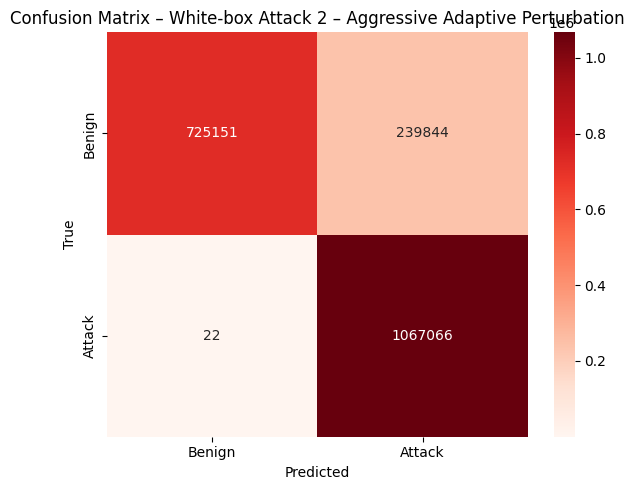

In [7]:
X_adv2 = X.copy()
y_adv2 = y.copy()
attack_indices = y_adv2[y_adv2 == 1].index

features_to_perturb_2 = features_to_perturb_1

for feat in features_to_perturb_2:
    if feat in X_adv2.columns:
        values = X_adv2.loc[attack_indices, feat]
        # Invert logic: bigger change for bigger values
        scale = np.where(values < 1e-2, 0.1, np.where(values < 1, 0.2, 0.4))
        X_adv2.loc[attack_indices, feat] = values * (1 - scale)

print(f"Applied aggressive adaptive perturbation to {len(features_to_perturb_2)} features")

# === Evaluate
y_pred_adv2 = model.predict(X_adv2)
y_prob_adv2 = model.predict_proba(X_adv2)[:, 1]
evaluate_attack(y, y_pred_adv2, y_prob_adv2, title="White-box Attack 2 – Aggressive Adaptive Perturbation")


## White-box Attack 3: Feature Importance Guided Perturbation

In this attack, we:
- Extract the model’s top important features (white-box access)
- Apply large perturbations (up to -40%) **only on those key features**
- Simulate an informed attacker modifying what the model depends on most

This is more surgical and powerful than uniform perturbation.


Targeting top important features: ['total fwd packets', 'subflow fwd bytes', 'subflow fwd packets', 'total length of fwd packets', 'act_data_pkt_fwd', 'fwd iat total', 'active mean', 'active max', 'active min', 'fwd packet length std']
Applied feature-importance-based perturbation to 10 features on 1067088 attack rows
Classification Report – White-box Attack 3 – Feature Importance Guided
              precision    recall  f1-score   support

      Benign       1.00      0.75      0.86    964995
      Attack       0.82      1.00      0.90   1067088

    accuracy                           0.88   2032083
   macro avg       0.91      0.88      0.88   2032083
weighted avg       0.90      0.88      0.88   2032083

Accuracy:         0.8820
Precision:        0.8165
Recall:           1.0000
F1-Score:         0.8990
ROC AUC:          0.9335
Evasion Rate:  0.0007% (7 of 1067088 attacks evaded)


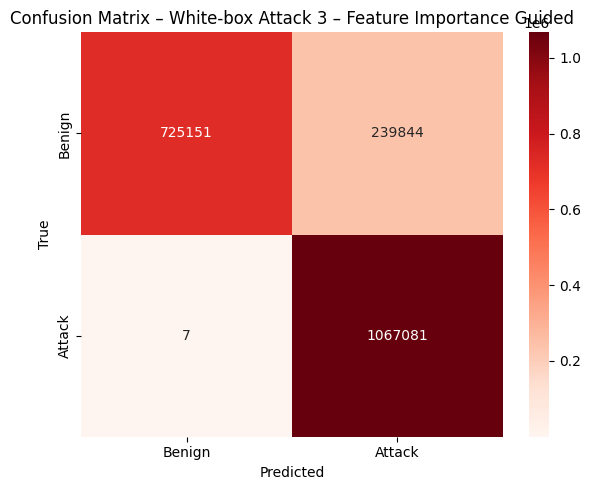

In [8]:
# === Clone for attack
X_adv3 = X.copy()
y_adv3 = y.copy()
attack_indices = y_adv3[y_adv3 == 1].index

# === Get top 10 most important features
importances = pd.Series(model.feature_importances_, index=X.columns)
top_feats = importances.sort_values(ascending=False).head(10).index.tolist()

print("Targeting top important features:", top_feats)

# === Apply strong perturbation (-40%) to only those features
for feat in top_feats:
    if feat in X_adv3.columns:
        X_adv3.loc[attack_indices, feat] *= 0.6  # reduce by 40%

print(f"Applied feature-importance-based perturbation to {len(top_feats)} features on {len(attack_indices)} attack rows")

# === Evaluate
y_pred_adv3 = model.predict(X_adv3)
y_prob_adv3 = model.predict_proba(X_adv3)[:, 1]
evaluate_attack(y, y_pred_adv3, y_prob_adv3, title="White-box Attack 3 – Feature Importance Guided")


## White-box Attack 4: Partial Benign Mimicry (Top-K Features Only)

This refined adversarial attack modifies only the **top 5 most important features** to look more like benign traffic.  
The attacker adjusts these selectively, blending realism with stealth.



Softer mimicry of features: ['total fwd packets', 'subflow fwd bytes', 'subflow fwd packets', 'total length of fwd packets', 'act_data_pkt_fwd', 'fwd iat total', 'active mean', 'active max']
Softly shifted 8 top features across 1067088 attack samples
Classification Report – White-box Attack 5 – Partial Benign Mimicry
              precision    recall  f1-score   support

      Benign       0.51      0.75      0.61    964995
      Attack       0.61      0.36      0.45   1067088

    accuracy                           0.54   2032083
   macro avg       0.56      0.55      0.53   2032083
weighted avg       0.57      0.54      0.53   2032083

Accuracy:         0.5435
Precision:        0.6126
Recall:           0.3554
F1-Score:         0.4498
ROC AUC:          0.7534
Evasion Rate:  64.4636% (687883 of 1067088 attacks evaded)


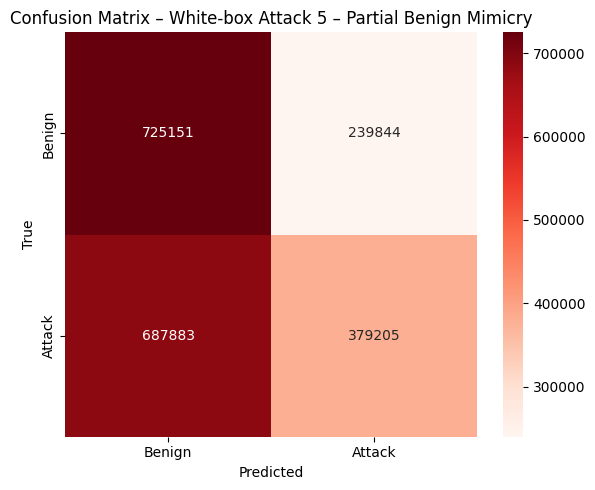

In [9]:
# === Clone again
X_adv5 = X.copy()
y_adv5 = y.copy()
attack_indices = y_adv5[y_adv5 == 1].index
benign_indices = y_adv5[y_adv5 == 0].index

# === Lighter targeting
importances = pd.Series(model.feature_importances_, index=X.columns)
top_k = 8  # fewer features
top_feats_5 = importances.sort_values(ascending=False).head(top_k).index.tolist()
print("Softer mimicry of features:", top_feats_5)

# === Benign stats
benign_stats = X_adv5.loc[benign_indices].agg(['mean', 'std']).T
benign_stats['std'] = benign_stats['std'].replace(0, 1e-6)

# === Mimic with blending: 90% original + 10% (mean + noise)
np.random.seed(42)
for feat in top_feats_5:
    if feat in X_adv5.columns:
        orig = X_adv5.loc[attack_indices, feat]
        benign_mean = benign_stats.loc[feat, 'mean']
        benign_std = benign_stats.loc[feat, 'std']
        noise = np.random.normal(loc=0, scale=0.2, size=len(attack_indices))
        mimic = benign_mean + noise * benign_std
        X_adv5.loc[attack_indices, feat] = 0.9 * orig + 0.1 * mimic.astype(float)

print(f"Softly shifted {top_k} top features across {len(attack_indices)} attack samples")


# === Predict
y_pred_adv5 = model.predict(X_adv5)
y_prob_adv5 = model.predict_proba(X_adv5)[:, 1]

# === Evaluate
evaluate_attack(y, y_pred_adv5, y_prob_adv5, title="White-box Attack 5 – Partial Benign Mimicry")


## White-box Attack 5: Benign Feature Distribution Mimicry

In this advanced white-box attack:
- We calculate the **mean and std** of benign samples per numeric feature.
- Then, we transform each attack sample’s feature values to match the **mean of the benign distribution**, plus a small noise offset.
- This simulates an attacker who has profiled normal traffic and is crafting packets that “look benign” in every measurable way.


Transformed 1067088 attack samples to mimic benign stats for all features
Classification Report – White-box Attack 4 – Benign Feature Mimicry
              precision    recall  f1-score   support

      Benign       0.40      0.75      0.53    964995
      Attack       0.00      0.00      0.00   1067088

    accuracy                           0.36   2032083
   macro avg       0.20      0.38      0.26   2032083
weighted avg       0.19      0.36      0.25   2032083

Accuracy:         0.3569
Precision:        0.0000
Recall:           0.0000
F1-Score:         0.0000
ROC AUC:          0.5715
Evasion Rate:  100.0000% (1067088 of 1067088 attacks evaded)


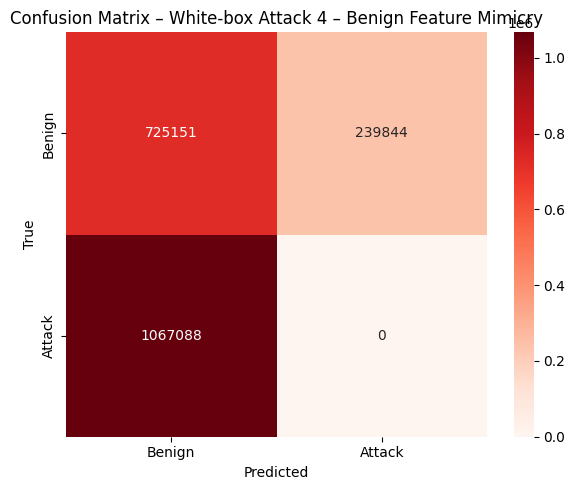

In [10]:
# === Clone for manipulation
X_adv4 = X.copy()
y_adv4 = y.copy()

# === Get indices
attack_indices = y_adv4[y_adv4 == 1].index
benign_indices = y_adv4[y_adv4 == 0].index

# === Compute benign feature stats
benign_stats = X_adv4.loc[benign_indices].agg(['mean', 'std']).T
benign_stats['std'] = benign_stats['std'].replace(0, 1e-6)  # avoid divide-by-zero

# === Shift attack samples to mimic benign mean ± small random noise (up to 1 std)
np.random.seed(42)  # for reproducibility
for feature in benign_stats.index:
    if feature in X_adv4.columns:
        noise = np.random.normal(loc=0.0, scale=0.3, size=len(attack_indices))
        X_adv4.loc[attack_indices, feature] = (
            benign_stats.loc[feature, 'mean'] +
            noise * benign_stats.loc[feature, 'std']
        )

print(f"Transformed {len(attack_indices)} attack samples to mimic benign stats for all features")

# === Predict
y_pred_adv4 = model.predict(X_adv4)
y_prob_adv4 = model.predict_proba(X_adv4)[:, 1]

# === Evaluate
evaluate_attack(y, y_pred_adv4, y_prob_adv4, title="White-box Attack 4 – Benign Feature Mimicry")
